
# Using Large Langualge Models for Well Log Classification


Using LLMs to represent numerical data into embeddings is a promising paradigm for dealing with tabular data. More information about using LLms for tabular data can be found in the following papers [ref1](https://arxiv.org/html/2408.11854v1#:~:text=Our%20findings%20show%20that%20while,improvements%20to%20maximize%20their%20effectiveness.), [ref2](https://arxiv.org/pdf/2402.01713).
This notebook explores the idea of using Large Language Models (LLMs) for pre-processing well log data. The data that we will use come from the [SEG machine learning contest](https://github.com/seg/2016-ml-contest/blob/master/Facies_classification.ipynb) that took place in 2016. For more info about the geological background of the data you can check the following papers [ref1](https://www.kgs.ku.edu/PRS/publication/2003/ofr2003-50.pdf), [ref2](https://www.sciencedirect.com/science/article/abs/pii/S0098300406001956?via%3Dihub).  

First we will explore and briefly describe the data. We will then develop a vanila pre-processing pipeline to condition the data. Next we will apply some conventional machine learning approaches (logistic regression, SVM, random forest, XGBoost) and test their performance. We will use these results as a baseline for comparison purposes.

The conditioned and pre-processed data will then be given as inputs into different LLMs from [OpenAI](https://openai.com/index/new-embedding-models-and-api-updates/) to transform the data into embenddings. Finally, we will use these embenddings as inputs to simple classifiers -logistic regression and SVM- and compare the results to conventional approaches.

\\
\
*This notebook was made for Google Colab



# Requirements

To run this notebook you will need an account with [OpenAI](https://openai.com/), enough credits to use the [API services](https://platform.openai.com/docs/overview), and an API key. In this section we will mount Google drive; import all the packages that we will use; install OpenAI; and enter an API key.

Also we will test the function to transform a text sequence into numerical embeddings and outline the three embeddings models that we will use:

* text-embedding-ada-002
* text-embedding-3-large
* text-embedding-3-small

For more information on the embedding models used check [here](https://platform.openai.com/docs/guides/embeddings).

In [ ]:
# Mount Google Drive
# This is just for Google Colab
from google.colab import drive
drive.mount('/content/drive')

# Set the directory at MyDrive
# This is just when running on Google colab
import os

os.chdir('/content/drive/MyDrive/')

Mounted at /content/drive


In [ ]:
# Install openai
!pip install openai

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 365.7/365.7 kB 20.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.4/76.4 kB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 6.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 318.9/318.9 kB 24.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 4.6 MB/s eta 0:00:00


In [ ]:
# Install requirements to run KANs
!pip install scikit-learn==1.5.1
!pip install imodelsx

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.4/13.4 MB 95.9 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.3.2
    Uninstalling scikit-learn-1.3.2:
      Successfully uninstalled scikit-learn-1.3.2
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.4/50.4 kB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.5/115.5 kB 8.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 527.3/527.3 kB 27.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 243.0/243.0 kB 18.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 46.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 11.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 396.4/396.4 kB 29.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 290.2/290.2 kB 23.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━

In [ ]:
# Import packages
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
import json
from imblearn.over_sampling import SMOTE
from sklearn import preprocessing as pr
from scipy import stats
import openai
import seaborn as sns
import matplotlib.colors as colors
from mpl_toolkits.axes_grid1 import make_axes_locatable
from sklearn.impute import KNNImputer
from sklearn import manifold
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score
import xgboost as xgb
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from tqdm.auto import tqdm
from numpy.linalg import norm
import random
from imodelsx import KANClassifier
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
import time
import sys
import re

In [ ]:
# Setting up an API key
client = openai.OpenAI(api_key = "Your API Key")


# The three different embending models from OpenAI
emb_0 = "text-embedding-ada-002"
emb_1 = "text-embedding-3-large"
emb_2 = "text-embedding-3-small"

# Function that transforms a given text into embeddings
def get_embedding(text, model=emb_1):
   # text: Input string
   text = text.replace("\n", " ")

   # Return is a list with numerical parameters
   # lenngth of the list for emb_0 1536
   # lenngth of the list for emb_1 3072
   # lenngth of the list for emb_2 1536
   return client.embeddings.create(input = [text], model=model, encoding_format="float").data[0].embedding

# Example
text = "This is an example of how a string is transformed to embeddings"
xc = get_embedding(text, model=emb_2)

print("Original text: ")
print("==============")
print(text)
print("")
print("Embeddings: ")
print("==============")
print(xc)


Original text: 
This is an example of how a string is transformed to embeddings

Embeddings: 
[0.016877318, -0.025242807, -0.017279739, -0.010493448, -0.010255653, -0.042754244, 0.020133274, 0.027779283, 0.007731372, 0.028023176, 0.0060485182, -0.04526633, -0.02582815, -0.043924924, -0.011975091, 0.023633122, 0.023694094, 0.0035730158, -0.028876796, 0.025340365, -0.03209617, -0.0392422, 0.02668177, 0.07048475, 0.0048564966, -0.0039236103, -0.014974961, 0.035632603, 0.021852711, -0.0005582837, -0.018633338, -0.041632343, 0.026535435, -0.055607345, 0.017487047, 0.05150996, -0.004816864, -0.017974831, -0.029949922, 0.030071868, 0.0056582913, 0.022364885, -0.042729855, 0.014657902, -0.0074326047, 0.07682594, -0.035754547, -0.013718917, -0.018230917, 0.04380298, -0.04951005, 0.0010807458, -0.013816474, -0.006274118, -0.009536172, 0.010481253, -0.014340842, 0.023352645, -0.0232307, -0.016877318, -0.01258482, -0.020938117, -0.008767912, 0.01332869, 0.003037978, 0.023316063, -0.03692523, 0.044

In [ ]:
# Function for plotting well log data
# Taken from
# https://github.com/seg/2016-ml-contest/blob/master/Facies_classification.ipynb

def make_facies_log_plot(logs):

    facies_colors = ['#F4D03F', '#F5B041','#DC7633','#6E2C00',
       '#1B4F72','#2E86C1', '#AED6F1', '#A569BD', '#196F3D']


    #make sure logs are sorted by depth
    logs = logs.sort_values(by='Depth')
    cmap_facies = colors.ListedColormap(
            facies_colors[0:len(facies_colors)], 'indexed')

    ztop=logs.Depth.min(); zbot=logs.Depth.max()

    cluster=np.repeat(np.expand_dims(logs['Facies'].values,1), 100, 1)

    f, ax = plt.subplots(nrows=1, ncols=6, figsize=(8, 12))
    ax[0].plot(logs.GR, logs.Depth, '-g')
    ax[1].plot(logs.ILD_log10, logs.Depth, '-')
    ax[2].plot(logs.DeltaPHI, logs.Depth, '-', color='0.5')
    ax[3].plot(logs.PHIND, logs.Depth, '-', color='r')
    ax[4].plot(logs.PE, logs.Depth, '-', color='black')
    im=ax[5].imshow(cluster, interpolation='none', aspect='auto',
                    cmap=cmap_facies,vmin=1,vmax=9)

    divider = make_axes_locatable(ax[5])
    cax = divider.append_axes("right", size="20%", pad=0.05)
    cbar=plt.colorbar(im, cax=cax)
    cbar.set_label((17*' ').join([' 1 ', '2', '3',
                                '4', ' 5 ', ' 6 ', ' 7  ',
                                ' 8 ', ' 9 ']))
    cbar.set_ticks(range(0,1)); cbar.set_ticklabels('')

    for i in range(len(ax)-1):
        ax[i].set_ylim(ztop,zbot)
        ax[i].invert_yaxis()
        ax[i].grid()
        ax[i].locator_params(axis='x', nbins=3)

    ax[0].set_xlabel("GR")
    ax[0].set_ylabel("Depth")

    ax[0].set_xlim(logs.GR.min(),logs.GR.max())
    ax[1].set_xlabel("ILD_log10")
    ax[1].set_xlim(logs.ILD_log10.min(),logs.ILD_log10.max())
    ax[2].set_xlabel("DeltaPHI")
    ax[2].set_xlim(logs.DeltaPHI.min(),logs.DeltaPHI.max())
    ax[3].set_xlabel("PHIND")
    ax[3].set_xlim(logs.PHIND.min(),logs.PHIND.max())
    ax[4].set_xlabel("PE")
    ax[4].set_xlim(logs.PE.min(),logs.PE.max())
    ax[5].set_xlabel('Facies')

    ax[1].set_yticklabels([]); ax[2].set_yticklabels([]); ax[3].set_yticklabels([])
    ax[4].set_yticklabels([]); ax[5].set_yticklabels([])
    ax[5].set_xticklabels([])
    f.suptitle('Well: %s'%logs.iloc[0]['Well Name'], fontsize=14,y=0.94)

# Exploring the Data

The data consists of 8 wells saved in a .csv file named "training_data.csv". The inputs are 6 wireline log measurements and two indicator variables; and the output is the facies label that we need to recover from the inputs. In an abstract manner, this is a tabular data problem with 8 dimensions where we try to map the causal relationship between the inputs (6 log measurements and two indicators) and the labels (facies column). We will exclude one well from the training process in order to use it as an unknown well for testing purposes.

In [ ]:
# Open the csv and print it
training_data = pd.read_csv("/content/drive/MyDrive/training_data.csv")
training_data

,Facies,Formation,Well Name,Depth,GR,ILD_log10,DeltaPHI,PHIND,PE,NM_M,RELPOS
0,3,A1 SH,SHRIMPLIN,2793.0,77.450,0.664,9.900,11.915,4.600,1,1.000
1,3,A1 SH,SHRIMPLIN,2793.5,78.260,0.661,14.200,12.565,4.100,1,0.979
2,3,A1 SH,SHRIMPLIN,2794.0,79.050,0.658,14.800,13.050,3.600,1,0.957
3,3,A1 SH,SHRIMPLIN,2794.5,86.100,0.655,13.900,13.115,3.500,1,0.936
4,3,A1 SH,SHRIMPLIN,2795.0,74.580,0.647,13.500,13.300,3.400,1,0.915
...,...,...,...,...,...,...,...,...,...,...,...
3227,5,C LM,CHURCHMAN BIBLE,3120.5,46.719,0.947,1.828,7.254,3.617,2,0.685
3228,5,C LM,CHURCHMAN BIBLE,3121.0,44.563,0.953,2.241,8.013,3.344,2,0.677
3229,5,C LM,CHURCHMAN BIBLE,3121.5,49.719,0.964,2.925,8.013,3.190,2,0.669
3230,5,C LM,CHURCHMAN BIBLE,3122.0,51.469,0.965,3.083,7.708,3.152,2,0.661


The column codes correspond to:
* Facies: Rock type
* Formation: Geological formation
* Well name: Name of the borehole
* Depth: The depth that the measurement took place
* GR: Gamma ray
* ILD_log10: resistivity logging
* DeltaPHI: Neutron-density porosity different
* PHIND: Average neutron-density porosity
* PE: Photoelectric effect
* NM_M: Non marine - marine indicator
* RELPOS: Relative position

The column *Facies* contains the labels (integers from 1-9) that we want to predict. This is multi-class classification problem with a total of 9 classes. Each class corresponds to a specific rock formation:

* 1. Nonmarine sandstone
* 2. Nonmarine coarse siltstone
* 3. Nonmarine fine siltstone
* 4. Marine siltstone and shale
* 5. Mudstone (limestone)
* 6. Wackestone (limestone)
* 7. Dolomite
* 8. Packstone-grainstone (limestone)
* 9. Phylloid-algal bafflestone (limestone)

Although we approach this problem as a classification, in practise these facies are not fully discreet and there are transition facies between them. In particular

* Facies 1 is close to facies 2
* Facies 2 is close to facies 1, 3
* Facies 3 is close to facies 2
* Facies 4 is close to facies 5
* Facies 5 is close to facies 4,6
* Facies 6 is close to facies 5,7
* Facies 7 is close to facies 6,8
* Facies 8 is close to facies 6,7,9
* Facies 9 is close to facies 7, 8


The facies are not equally distributed in the dataset, and there are some imbalances that can negatively affect the overall performance of machine learning.

Frequency         Facies
22.83%:    Nonmarine coarse siltstone
19.03%:    Nonmarine fine siltstone
15.41%:    Packstone-grainstone
14.29%:    Wackestone
8.01%:    Nonmarine sandstone
6.71%:    Mudstone
5.69%:    Marine siltstone and shale
4.98%:    Phylloid-algal bafflestone
3.03%:    Dolomite


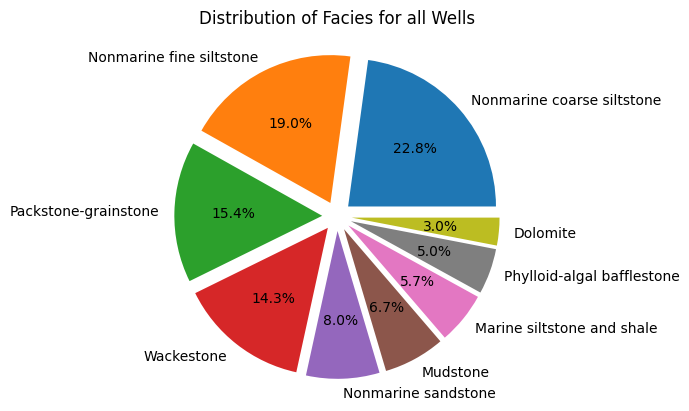

In [ ]:
# Dictionary with the facies names and their corresponding integer label
facies = {1: "Nonmarine sandstone", 2: "Nonmarine coarse siltstone", 3: "Nonmarine fine siltstone", 4: "Marine siltstone and shale",
          5: "Mudstone", 6: "Wackestone", 7: "Dolomite", 8: "Packstone-grainstone", 9: "Phylloid-algal bafflestone"}

# The percentage of different facies in the data
facies_counts = np.round(100*training_data['Facies'].value_counts()/training_data.shape[0],2)

# Print the percentage of different facies
print("Frequency         Facies")
print("=========================")
for i, b in enumerate(facies_counts):
    print("{}%:    {}".format(b, facies[facies_counts.index[i]]))

# Plot pie chart of the different rock facies
plt.figure()
facies_counts.index = facies_counts.index.map(facies)
explode = (0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1)
plt.pie(facies_counts, labels = facies_counts.index, autopct='%1.1f%%', explode = explode)
plt.title('Distribution of Facies for all Wells')
plt.show()

From the above it is evident that many facies are underepresented in the data, which can potentially make classifiers biased against them.

Next we will explore the 8 diffferent wells, how many data they consist off, the overall quality of the data, and the facies distribution in each well.

In [ ]:
# Print the different wells and the total number of data in each well
well_names = training_data['Well Name'].unique()
print('Number of Data          Well name')
print("=================================")
for i in well_names:
    print("{}:                 {}".format(training_data.loc[training_data["Well Name"] == i].shape[0], i))

Number of Data          Well name
471:                 SHRIMPLIN
449:                 SHANKLE
461:                 LUKE G U
501:                 CROSS H CATTLE
415:                 NOLAN
68:                 Recruit F9
463:                 NEWBY
404:                 CHURCHMAN BIBLE


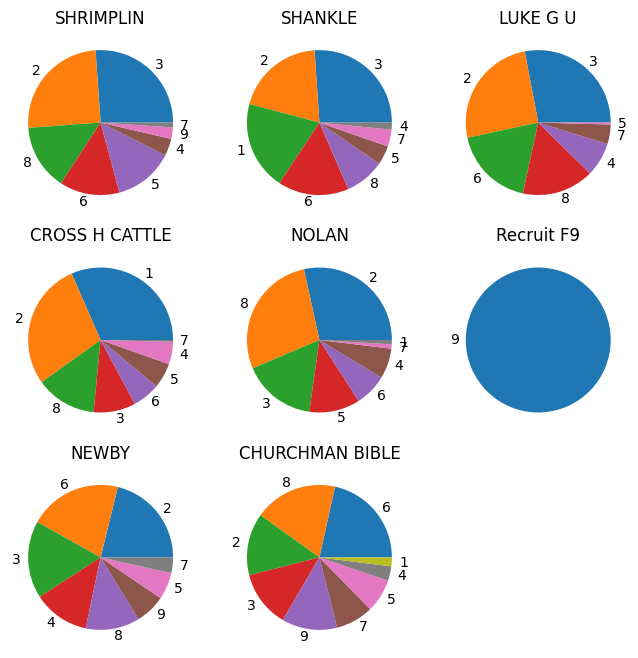

In [ ]:
# Plot the piecharts of the facies for each well
plt.figure(figsize = (8,8))
for ic, i in enumerate(well_names):
    temp_data = training_data.loc[training_data["Well Name"] == i]

    # The percentage of different facies in the data
    facies_counts = np.round(100*temp_data['Facies'].value_counts()/temp_data.shape[0],2)

    # Plot pie chart of the different rock facies
    plt.subplot(3,3,ic+1)
    plt.pie(facies_counts, labels = facies_counts.index)
    plt.title(i)
plt.show()

From the above it is apparent that the Well *Recruit F9* has lower number of data and the data are very biased to a specific class. Because of these we decided to drop *Recruit F9* from the data.

Therefore we have 7 wells in total, and one will be kept for testing purposes i.e. 6 wells for training and 1 well for testing. The well *LUKE G U* is very representative for the facies observed in the area, and therefore it is selected as the testing well.

Conclusively, the algorithms will be trained using the wells SHRIMPLIN, SHANKLE, CROSS H CATTLE, NOLAN, NEWBY and CHURCHMAN BIBLE; and tested in the well LUKE G U.


In [ ]:
# Drop the well Recruit F9 from the data
training_data = training_data[training_data['Well Name'] != 'Recruit F9']

Before we move to exploring the statistical properties of the data, it would be beneficial to plot the measurements for different wells, to visualise how the data look like.

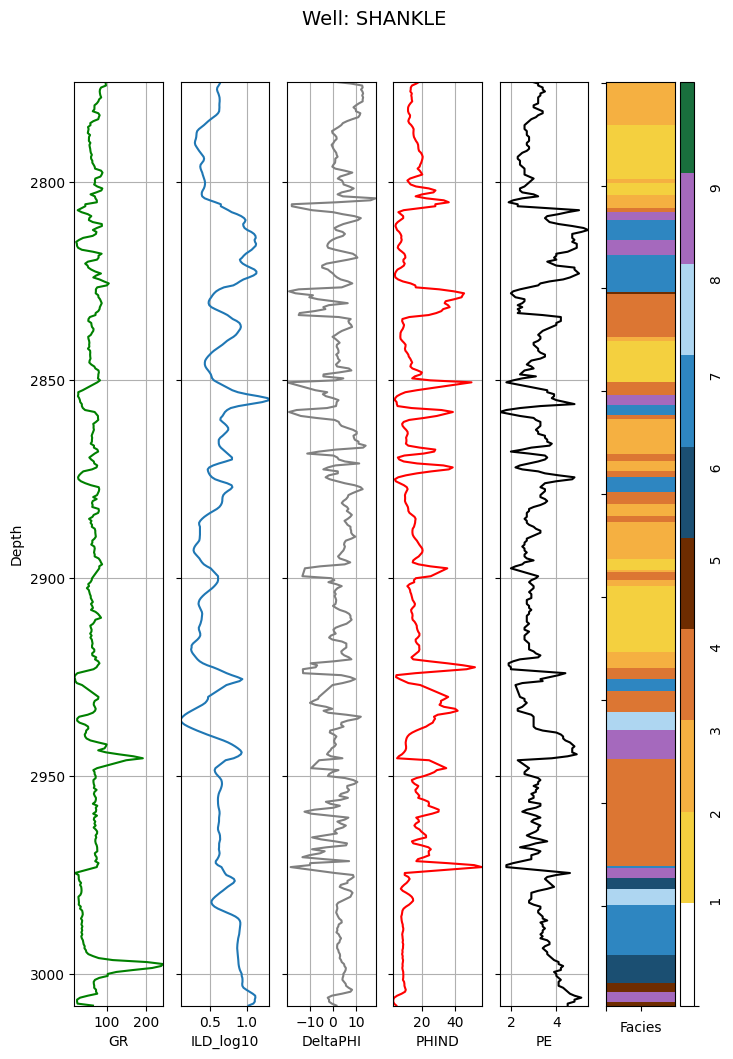

In [ ]:
# Plot the log data for the Well "SHANKLE"
make_facies_log_plot(training_data.loc[training_data["Well Name"] == "SHANKLE"])

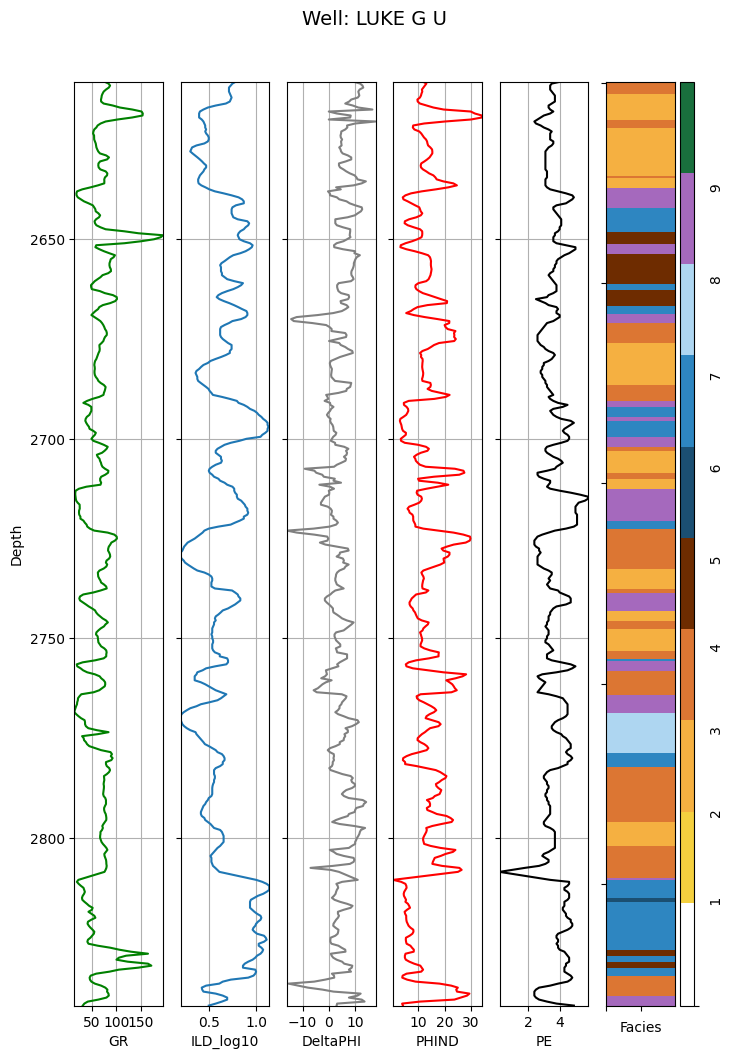

In [ ]:
# Plot the log data for the Well "LUKE G U"
make_facies_log_plot(training_data.loc[training_data["Well Name"] == "LUKE G U"])

Next we will explore the statistical characteristics of the data. First we check the mean, std, min, max etc. for the non-categorical data

In [ ]:
# Outline the statistical properties of the features for all the wells apart from Recruit F9 that was dropped before
training_data.describe()

,Facies,Depth,GR,ILD_log10,DeltaPHI,PHIND,PE,NM_M,RELPOS
count,3164.000000,3164.000000,3164.000000,3164.000000,3164.000000,3164.000000,3164.000000,3164.000000,3164.000000
mean,4.323641,2872.331226,66.596186,0.644328,3.605271,13.489657,3.687710,1.487674,0.521835
std,2.438403,129.957200,30.677758,0.240368,5.271850,7.756242,0.859788,0.499927,0.287663
min,1.000000,2573.500000,13.250000,-0.025949,-21.832000,0.550000,0.200000,1.000000,0.010000
25%,2.000000,2787.000000,48.431000,0.493000,1.200000,8.308000,3.100000,1.000000,0.275750
50%,3.000000,2889.500000,66.255000,0.624141,3.600000,12.117500,3.500000,1.000000,0.528000
75%,6.000000,2975.500000,79.894500,0.814000,6.504250,16.415000,4.277000,2.000000,0.772000
max,9.000000,3122.500000,361.150000,1.480000,18.600000,84.400000,8.094000,2.000000,1.000000


We notice that there is a big variation of ranges between different features. This can greatly affect some machine learning algorithms such as neural networks, SVM, logistic regression etc..

Next we will explore potential correlations between features using correlation matrix and pair plot (scatterplot matrix).

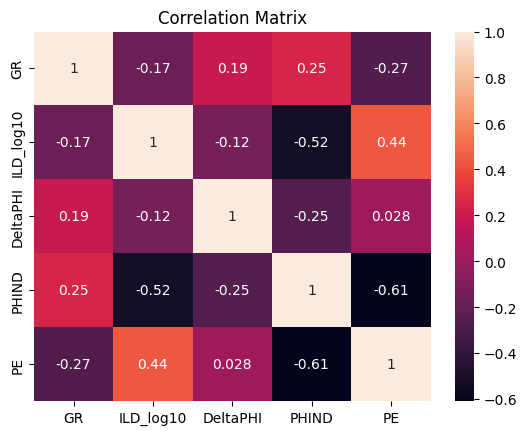

In [ ]:
# Remove the non numerical data
num_data = training_data.drop(["Well Name", "Facies", "Formation", "Depth", "NM_M", "RELPOS"],axis = 1)

# Calculating the correlation matrix
correlation_matrix = num_data.corr()
sns.heatmap(correlation_matrix, annot =True)
plt.title('Correlation Matrix')
plt.show()

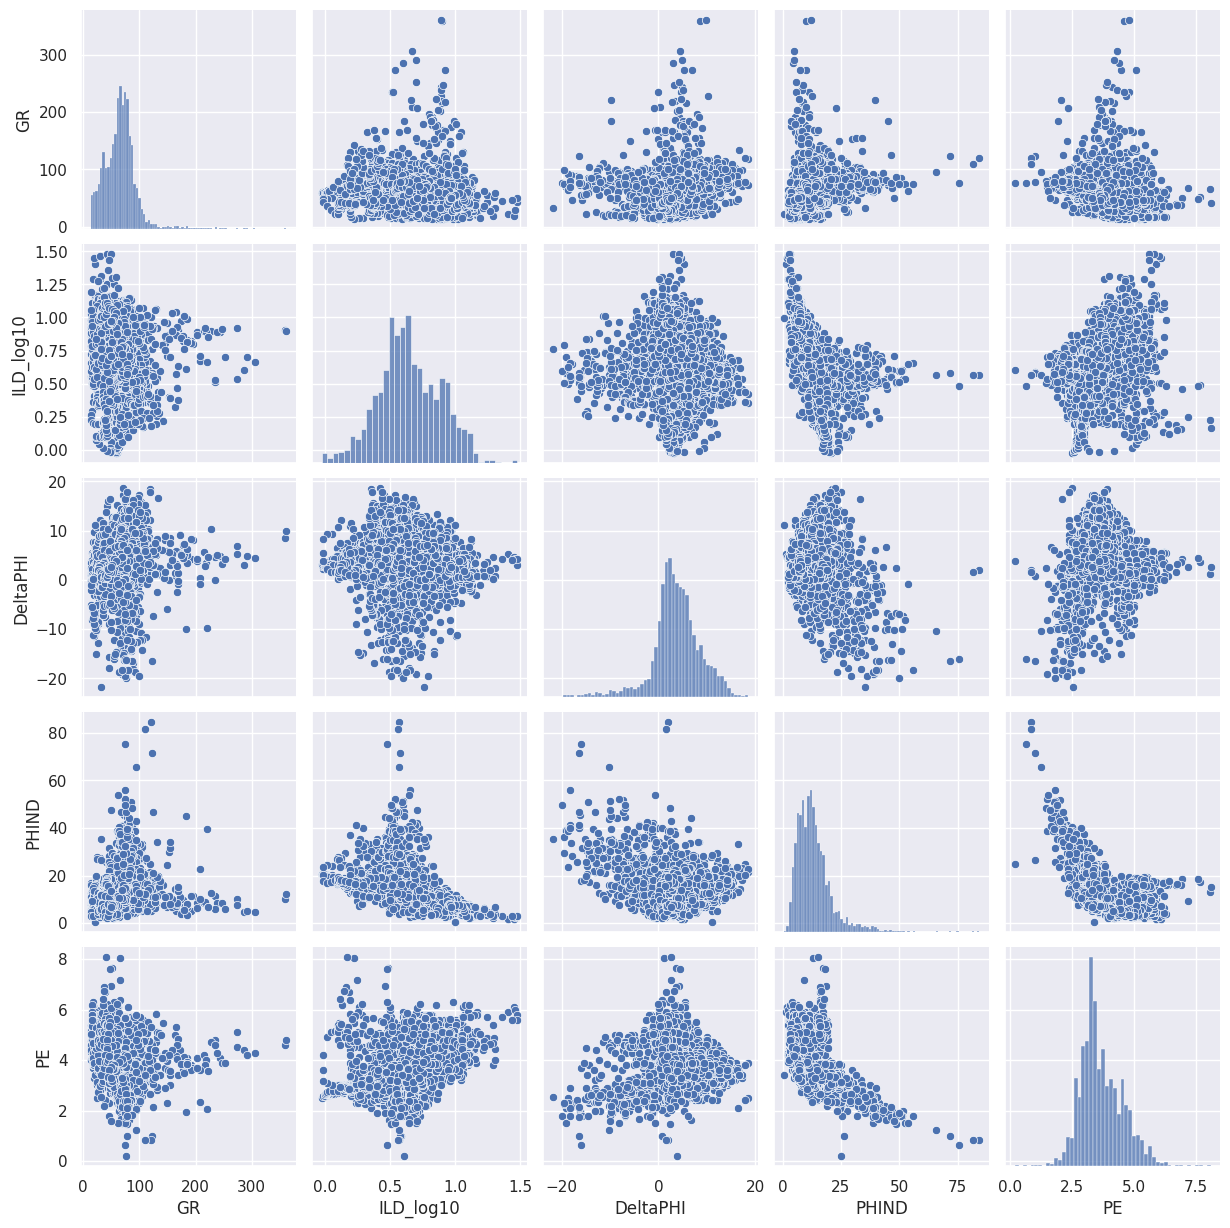

In [ ]:
# Plotting the pairplot
sns.set()
sns.pairplot(num_data)

It is apparent that there are no clear linear correlations between features. A low level non-linear correlation exists between *PE* and *PHIND*, which is a good argument for potentially removing *PE* from the data in an effort to reduce the dimensions of the problem.

The distributions are fairly normal with some clear outliers that will probably need to be removed.

# Processing and Conditioning the Data

In this chapter we will apply a set of processing steps in order to condition the data for machine learning. In particular:

* Make categorical data into numerical
* Augment the data using the first derivative with respect to depth
* Separate training and testing data
* Isolate the labels from the input features
* Scale the data (this is not necessary for random forest and XGboost but it's a good practice)
* Remove outliers using z-score
* Impute the removed values using KNN
* Use SMOTE to deal with imbalanced classes



In [ ]:
# Transform "Formation" data into "Formation_codes" and then remove the initial "Formation" column
training_data['Formation'] = training_data['Formation'].astype('category')
training_data['Formation_codes'] = training_data['Formation'].cat.codes
training_data.drop(['Formation'], axis=1, inplace = True)


#  Augmenting the data calculating the derivative with respect to depth
#  The derivative will be calculated for these features
col = ['GR', 'ILD_log10', 'DeltaPHI', 'PHIND', 'PE',
       'NM_M', 'RELPOS']
# The names of the new features
col2 = ['Diff_GR', 'Diff_ILD_log10', 'Diff_DeltaPHI', 'Diff_PHIND', 'Diff_PE',
       'Diff_NM_M', 'Diff_RELPOS']

# Initialising the new features with zeros
training_data[[j for j in col2]] = None
wellname = np.unique(training_data['Well Name'])
for i in wellname:
    datt = training_data[training_data['Well Name'] == i]
    datt = datt.sort_values(by='Depth')
    for j in col:
        dt2 = datt[j].diff()/(datt['Depth'].diff()+0.001)
        dt2[dt2.index[0]] = dt2[dt2.index[1]]
        training_data.loc[training_data['Well Name'] == i, 'Diff_{}'.format(j)] = dt2


<ipython-input-18-1c0bd84eb386>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  training_data['Formation'] = training_data['Formation'].astype('category')
<ipython-input-18-1c0bd84eb386>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  training_data['Formation_codes'] = training_data['Formation'].cat.codes
<ipython-input-18-1c0bd84eb386>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/

In [ ]:
# Isolate data from "LUKE G U" borehole to be used as testing set
test=training_data.loc[training_data['Well Name'] == 'LUKE G U']
# Exclude "LUKE G U" borehole data from the training set
train=training_data.loc[training_data['Well Name'] != 'LUKE G U']

In [ ]:
# Set the labels for the training data
X_labels = train['Facies']
# Drop Formation, Well Name, Depth, they are not useful features (adding dimensions without adding information).
# Drop the Facies from the training data
X_data = train.drop(['Well Name', 'Depth','Facies'], axis=1)

# Set the labels for the testing data
T_labels = test['Facies']
# Drop Formation, Well Name, Depth, they are not useful features (adding dimensions without adding information).
# Drop the Facies from the training data
T_data = test.drop(['Well Name', 'Depth','Facies'], axis=1)

# Scale the training data and the testing data
scaler = pr.StandardScaler()
scaler.fit(X_data)
X_data=scaler.transform(X_data)
T_data=scaler.transform(T_data)

In [ ]:
# Remove outliers using Z-score.
z_scores = stats.zscore(X_data)
abs_z_scores = np.abs(z_scores)
# Remove all the values above +-1.5 standard deviation. This number is to be tuned
X_data[abs_z_scores > 1.5]=np.nan

# Impute the removed outliers with KNN with 20 neightboor points
imputer = KNNImputer(n_neighbors=20)
X_data = imputer.fit_transform(X_data)

In [ ]:
# Use SMOTE to balance the classes in the training data
oversample = SMOTE()
X_data_a, X_labels_a  = oversample.fit_resample(X_data,X_labels)

# Conventional Machine Learning Approaches

The data are now conditioned and seperated into training and testing data and the features into inputs and labels. In this section we will apply conventional machine learning methods for tabular data. In particular we will explore the following methods:

* Logistic Regression
* SVM + Kernel
* Random Forest
* XGBoost
* KAN

Before we start exploring these methods, first we will use t-SNE and PCA in order to project the data in different 2D spacea and see if there are any observable boundaries between the different classes.

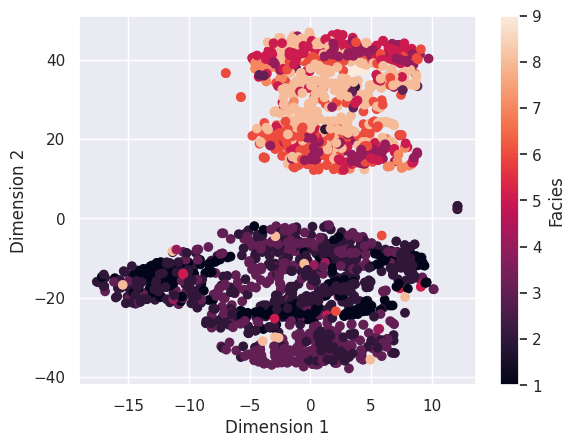

In [ ]:
# Apply t-SNE to project the data in a 2D space
#  We use just 2000 data to increase speed
X_embedded = manifold.TSNE(n_components = 2, learning_rate = "auto", init = 'random', perplexity =100).fit_transform(X_data[0:2000])
plt.scatter(X_embedded[:,0], X_embedded[:,1], c=X_labels[0:2000])
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
cbar = plt.colorbar()
cbar.set_label('Facies')
plt.show()

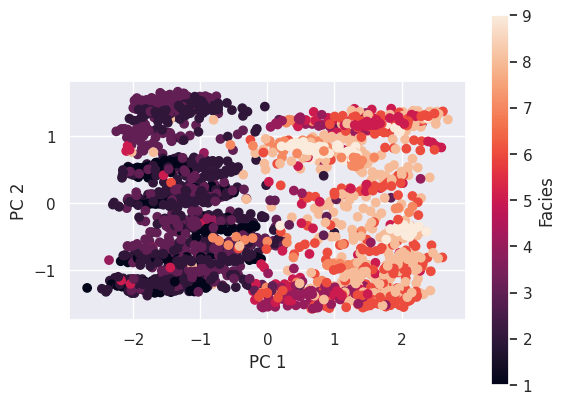

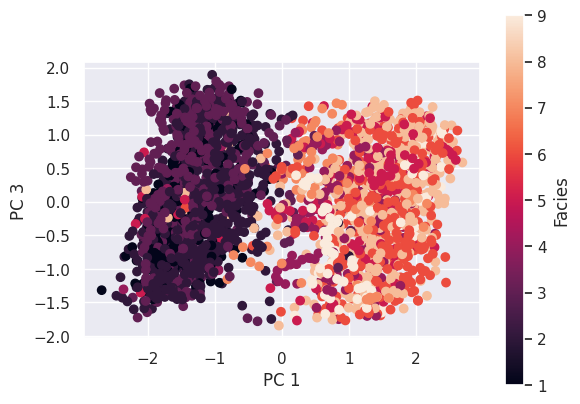

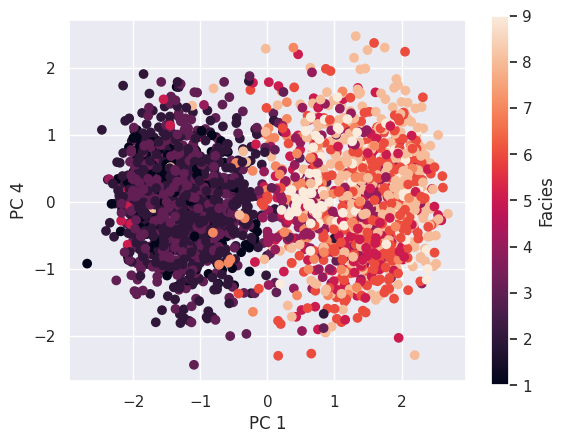

In [ ]:
# Apply PCA with 2 dimensions to project the data in a 2D space
pca = PCA(n_components = 4)
pc = pca.fit(X_data)
n_t = pc.transform(X_data)

# plt.figure(figsize = (8,8))
plt.scatter(n_t[:,0], n_t[:,1], c=X_labels)
plt.axis('scaled')
plt.xlabel('PC 1')
plt.ylabel('PC 2')
cbar = plt.colorbar()
cbar.set_label('Facies')
plt.show()
plt.scatter(n_t[:,0], n_t[:,2], c=X_labels)
plt.axis('scaled')
plt.xlabel('PC 1')
plt.ylabel('PC 3')
cbar = plt.colorbar()
cbar.set_label('Facies')
plt.show()
plt.scatter(n_t[:,0], n_t[:,3], c=X_labels)
plt.axis('scaled')
plt.xlabel('PC 1')
plt.ylabel('PC 4')
cbar = plt.colorbar()
cbar.set_label('Facies')
plt.show()




It is apparent that there are two clear clusters of classes. Distinguishing between facies 1-4 and 5-9 is even possible from the t-SNE projection. Classifying between 1-4 and 5-9 is not so straightforward, especially for the classes 5-9, as expected from the nature, the proximity, and the similarity of the classes 5-9 (see begining of this notebook).

F1 score equals with:  0.5683297180043384


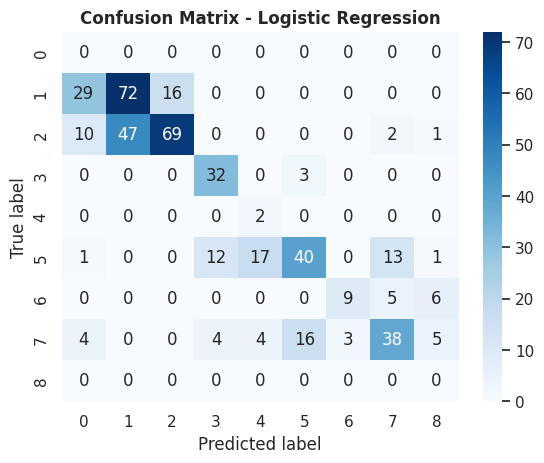

In [ ]:
# Logistic Regression
logi = LogisticRegression(max_iter = 300,penalty = 'l2', solver = 'newton-cg')
# Fit the augmented data after SMOTE
# logi.fit(X_data_a, X_labels_a)
# Fit data without SMOTE. For logistic regression SMOTE reduces the overall performance
logi.fit(X_data, X_labels)

pred = logi.predict(T_data)

# Print F1 score and plot confusion matrix
print("F1 score equals with:  {}". format(f1_score(T_labels, pred, average='micro')))
cm = confusion_matrix(T_labels, pred)
sns.heatmap(cm, annot=True, cmap="Blues", fmt="d")
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.title("Confusion Matrix - Logistic Regression", fontweight="bold")
plt.show()

F1 score equals with:  0.5466377440347071


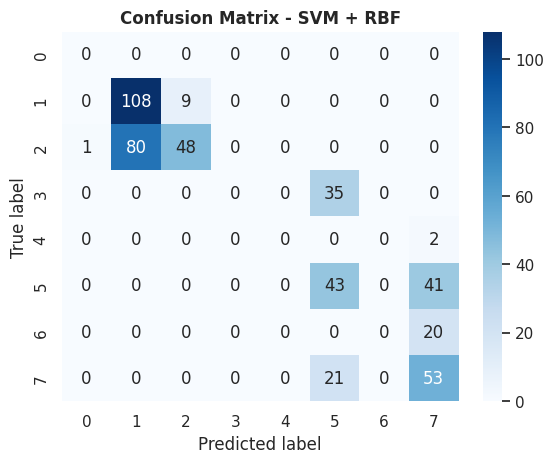

In [ ]:
# Support Vector Machines + RBF
clf = SVC(kernel = 'rbf', C=2, gamma = 0.001, decision_function_shape = 'ovo')
# Fit the augmented data after SMOTE
# clf.fit(X_data_a, X_labels_a)
# Fit data without SMOTE. For SVM SMOTE reduces the overall performance
clf.fit(X_data, X_labels)

pred = clf.predict(T_data)

# Print F1 score and plot confusion matrix
print("F1 score equals with:  {}". format(f1_score(T_labels, pred, average='micro')))
cm = confusion_matrix(T_labels, pred)
sns.heatmap(cm, annot=True, cmap="Blues", fmt="d")
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.title("Confusion Matrix - SVM + RBF", fontweight="bold")
plt.show()

F1 score equals with:  0.6247288503253796


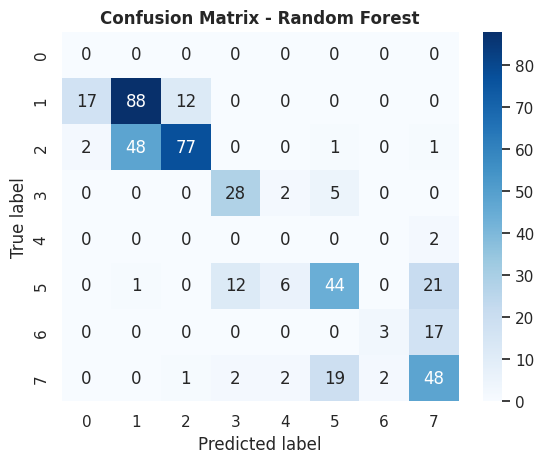

In [ ]:
# Random Forest
rf = RandomForestClassifier(n_estimators=250, max_depth=25, min_samples_leaf=5)
# Fit the augmented data after SMOTE
# rf.fit(X_data_a, X_labels_a)
# Fit data without SMOTE. For Random Forest SMOTE reduces the overall performance
rf.fit(X_data, X_labels)

pred = rf.predict(T_data)

# Print F1 score and plot confusion matrix
print("F1 score equals with:  {}". format(f1_score(T_labels, pred, average='micro')))
cm = confusion_matrix(T_labels, pred)
sns.heatmap(cm, annot=True, cmap="Blues", fmt="d")
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.title("Confusion Matrix - Random Forest", fontweight="bold")
plt.show()

F1 score equals with:  0.5488069414316703


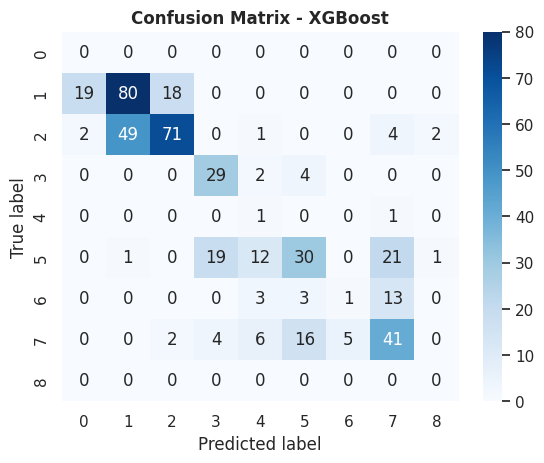

In [ ]:
# XGBoost
dtrain = xgb.DMatrix(X_data, label=X_labels)
dtest = xgb.DMatrix(T_data, label=T_labels)
params = {
    # 'tree_method': 'gpu_hist',
    'device': 'gpu',
    'objective': 'multi:softmax',
    'num_class': 10,
    'eval_metric': 'mlogloss',
    'max_depth': 25,
    'min_child_weight': 4,
    'gamma': 0,
}
# Train the model
num_rounds = 4000
xb = xgb.train(params, dtrain, num_rounds, evals=[(dtest, 'test')], early_stopping_rounds=10, verbose_eval = False)

# # Make predictions
pred = xb.predict(dtest)

# Print F1 score and plot confusion matrix
print("F1 score equals with:  {}". format(f1_score(T_labels, pred, average='micro')))
cm = confusion_matrix(T_labels, pred)
sns.heatmap(cm, annot=True, cmap="Blues", fmt="d")
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.title("Confusion Matrix - XGBoost", fontweight="bold")
plt.show()

 67%|██████▋   | 67/100 [00:10<00:05,  6.10it/s]


	Early stopping
F1 score equals with:  0.5856832971800434


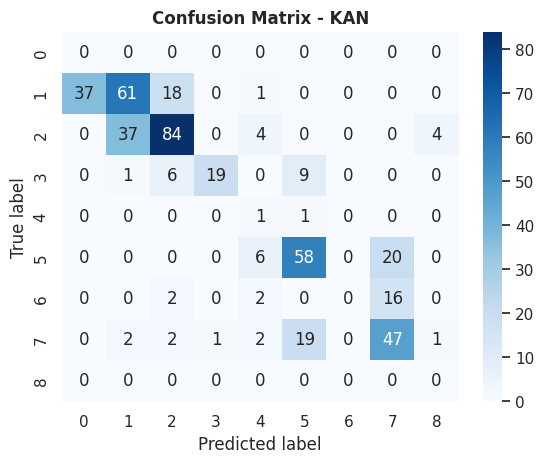

In [ ]:
# KAN classifier
kan = KANClassifier(device='cuda')

device = 'cuda'
kan = KANClassifier(hidden_layer_size=2048, device = 'cuda', regularize_activation=0.1, regularize_entropy=0.2)
kan.fit(np.array(X_data), np.array(X_labels))

pred = kan.predict(T_data)

# Print F1 score and plot confusion matrix
print("F1 score equals with:  {}". format(f1_score(T_labels, pred, average='micro')))
cm = confusion_matrix(T_labels, pred)
sns.heatmap(cm, annot=True, cmap="Blues", fmt="d")
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.title("Confusion Matrix - KAN", fontweight="bold")
plt.show()


# Large Language Models Embeddings

In this section we will first transform the data from numerical to strings, and then use LLMs from OpenAI to project the data in the latent space and retrieve the embeddings for each row.

To run this part you will need an account wiht [OpenAI](https://openai.com/) and enough credits to use the [API services](https://platform.openai.com/docs/overview) and an API key.

Below are the three different embeddings models that we will use:

* text-embedding-ada-002 (1536 elements)
* text-embedding-3-large  (3072 elements)
* text-embedding-3-small (1536 elements)

For more information on the embedding models used check [here](https://platform.openai.com/docs/guides/embeddings).

We use embeddings plus logistic regression and SVM. We ignoredd the other methods because the F1-score was around 0.45-0.5. Maybe with better hyper-parameters would perform better

In [ ]:
# Transform the numerical data to text; and get the embeddings
emb_train = []
# emb_labels = []
# Loop through all the training rows
for km, h in enumerate(tqdm(np.array(X_data), desc = "Training Set")):

    f_text = ""

    # Go from all the element of every row and add it to the text f_text
    for j in h:
        f_text = f_text + "{}, ".format(np.round(j,4))

    # Get the embeddings of f_text
    emb_train.append(get_embedding(f_text, model=emb_2))

# Same as previous segment but for the testing data
emb_test = []
for h in tqdm(np.array(T_data), desc = "Testing Set"):

    f_text = ""
    for j in h:
        f_text = f_text + "{}, ".format(np.round(j,4))

    emb_test.append(get_embedding(f_text, model=emb_2))


Training Set:   0%|          | 0/2703 [00:00<?, ?it/s]

Testing Set:   0%|          | 0/461 [00:00<?, ?it/s]

In [ ]:
# Scale the embeddings to have norm 1. This is not so important since it increases the performance slightly.
scaled_train = []
for h in emb_train:
    scaled_train.append(h/norm(h))

scaled_test = []
for h in emb_test:
    scaled_test.append(h/norm(h))

F1 score equals with:  0.5531453362255966


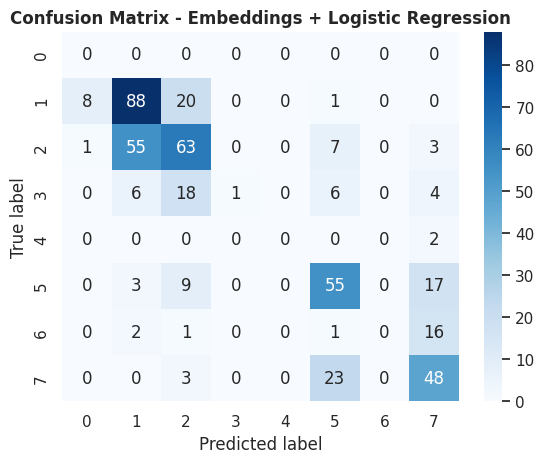

In [ ]:
# Apply logistic regression using the embeddings as inputs
logi = LogisticRegression(max_iter = 1700, penalty = 'l2', solver = 'newton-cg')

# clf1.fit(n_tt,cc)

logi.fit(np.array(scaled_train),X_labels)

# R_F1= clf.predict(n_tt2)
pred = logi.predict(np.array(scaled_test))



# Print F1 score and plot confusion matrix
print("F1 score equals with:  {}". format(f1_score(T_labels, pred, average='micro')))
cm = confusion_matrix(T_labels, pred)
sns.heatmap(cm, annot=True, cmap="Blues", fmt="d")
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.title("Confusion Matrix - Embeddings + Logistic Regression", fontweight="bold")
plt.show()

F1 score equals with:  0.5488069414316703


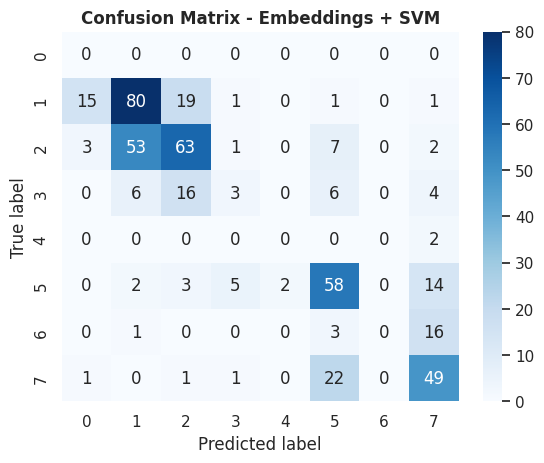

In [ ]:
# Apply SVM using the embeddings as inputs
# clf = SVC(kernel = 'rbf', C=2, gamma = 1, decision_function_shape = 'ovo')
clf = SVC(kernel = 'poly', C=2, gamma = 1.5, degree = 1, decision_function_shape = 'ovo')

# clf1.fit(n_tt,cc)
clf.fit(scaled_train,X_labels)
# R_F1= clf.predict(n_tt2)
pred = clf.predict(scaled_test)

# Print F1 score and plot confusion matrix
print("F1 score equals with:  {}". format(f1_score(T_labels, pred, average='micro')))
cm = confusion_matrix(T_labels, pred)
sns.heatmap(cm, annot=True, cmap="Blues", fmt="d")
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.title("Confusion Matrix - Embeddings + SVM", fontweight="bold")
plt.show()

Lastly we will compare the performance of logistic regression, random forest, and logistic regression with embeddings using different number of data to compare their performance. We will evaluate the F1-score using 1000 to 2700 with step 50.

In [ ]:
f1_log = []
f1_rf = []
f1_emb = []
f1_kan = []
for i in range(300,2700,50):

    random_integers = random.sample(range(0, 2700), i)
    logi = LogisticRegression(max_iter = 300)
    logi.fit(np.array(X_data)[random_integers], np.array(X_labels)[random_integers])
    pred = logi.predict(T_data)
    f1_log.append(f1_score(T_labels, pred, average='micro'))

    rf = RandomForestClassifier(n_estimators=250, max_depth=25, min_samples_leaf=5)
    rf.fit(np.array(X_data)[random_integers], np.array(X_labels)[random_integers])
    pred = rf.predict(T_data)
    f1_rf.append(f1_score(T_labels, pred, average='micro'))

    kan = KANClassifier(device='cuda')

    device = 'cuda'
    kan = KANClassifier(hidden_layer_size=2048, device = 'cuda', regularize_activation=0.1, regularize_entropy=0.2)
    kan.fit(np.array(X_data)[random_integers], np.array(X_labels)[random_integers])
    pred = kan.predict(T_data)
    f1_kan.append(f1_score(T_labels, pred, average='micro'))


    logi = LogisticRegression(max_iter = 1700)
    logi.fit(np.array(scaled_train)[random_integers],np.array(X_labels)[random_integers])
    pred = logi.predict(scaled_test)
    f1_emb.append(f1_score(T_labels, pred, average='micro'))





 63%|██████▎   | 63/100 [00:01<00:01, 35.81it/s]


	Early stopping


 70%|███████   | 70/100 [00:02<00:01, 28.08it/s]


	Early stopping


 65%|██████▌   | 65/100 [00:02<00:01, 22.78it/s]


	Early stopping


 72%|███████▏  | 72/100 [00:03<00:01, 21.96it/s]


	Early stopping


 62%|██████▏   | 62/100 [00:03<00:02, 15.70it/s]


	Early stopping


 63%|██████▎   | 63/100 [00:04<00:02, 13.76it/s]


	Early stopping


 69%|██████▉   | 69/100 [00:05<00:02, 13.18it/s]


	Early stopping


 66%|██████▌   | 66/100 [00:05<00:02, 13.04it/s]


	Early stopping


 64%|██████▍   | 64/100 [00:04<00:02, 12.94it/s]


	Early stopping


 64%|██████▍   | 64/100 [00:05<00:02, 12.18it/s]


	Early stopping


 65%|██████▌   | 65/100 [00:05<00:03, 11.51it/s]


	Early stopping


 64%|██████▍   | 64/100 [00:05<00:03, 11.21it/s]


	Early stopping


 63%|██████▎   | 63/100 [00:05<00:03, 10.96it/s]


	Early stopping


 66%|██████▌   | 66/100 [00:06<00:03, 10.36it/s]


	Early stopping


 66%|██████▌   | 66/100 [00:06<00:03,  9.52it/s]


	Early stopping


 67%|██████▋   | 67/100 [00:06<00:03,  9.97it/s]


	Early stopping


 62%|██████▏   | 62/100 [00:06<00:04,  8.99it/s]


	Early stopping


 63%|██████▎   | 63/100 [00:07<00:04,  8.96it/s]


	Early stopping


 64%|██████▍   | 64/100 [00:07<00:04,  8.15it/s]


	Early stopping


 62%|██████▏   | 62/100 [00:08<00:05,  7.43it/s]


	Early stopping


 67%|██████▋   | 67/100 [00:08<00:04,  7.56it/s]


	Early stopping


 60%|██████    | 60/100 [00:08<00:05,  7.45it/s]


	Early stopping


 65%|██████▌   | 65/100 [00:09<00:05,  6.58it/s]


	Early stopping


 66%|██████▌   | 66/100 [00:09<00:04,  6.88it/s]


	Early stopping


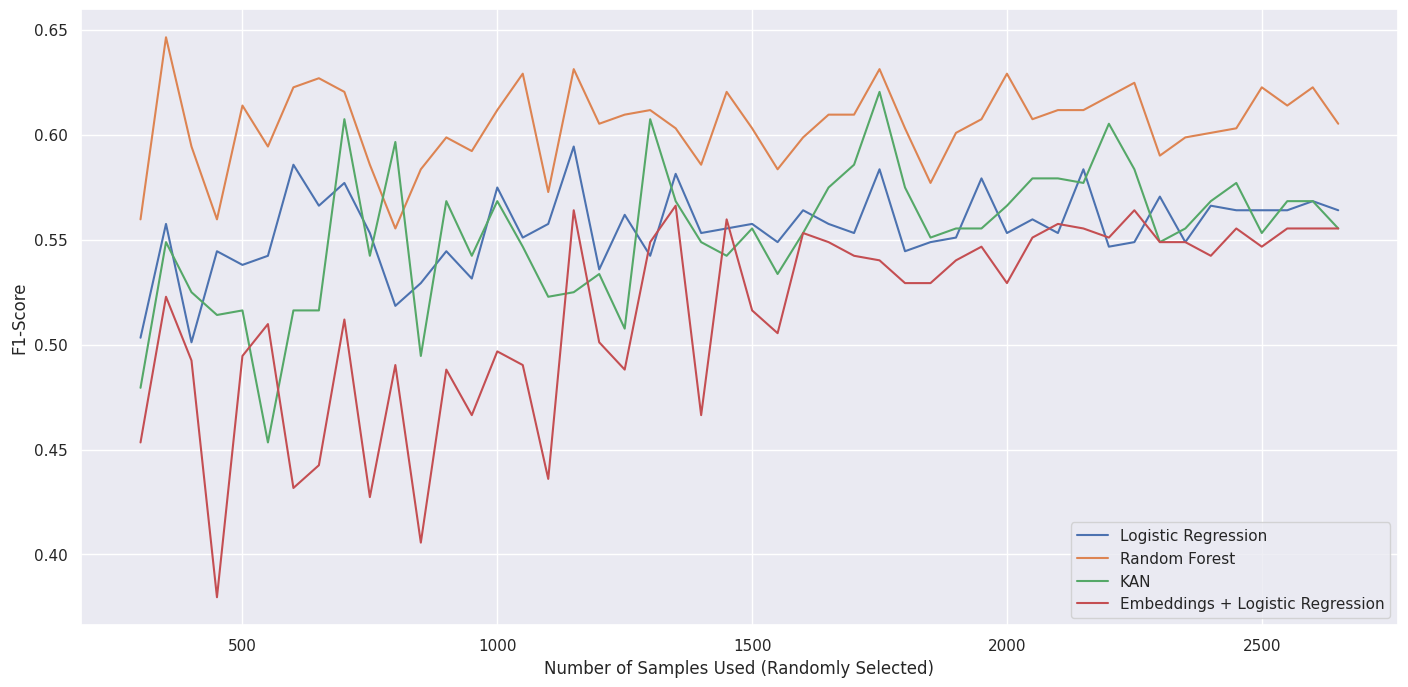

In [ ]:
# Plot the results
x = [i for i in range(300,2700,50)]
plt.figure(figsize = (17,8))
plt.plot(x,f1_log,x,f1_rf, x, f1_kan,x,f1_emb)
plt.xlabel('Number of Samples Used (Randomly Selected)')
plt.ylabel('F1-Score')
plt.legend(['Logistic Regression', 'Random Forest', 'KAN', 'Embeddings + Logistic Regression'])
plt.show()

In [ ]:
# Getting the raw unprocesed data to use as inputs to RAG.
# We do that because chatgpt already knows the underlying principles of well log lithology classification, and via RAG we want to build on that.

# Drop Formation, Well Name, Depth, they are not useful features (adding dimensions without adding information).
# Drop the Facies from the training data
X_data_new = train.drop(['Well Name', 'Depth','Facies'], axis=1)
X_data_new.drop(["Diff_GR", "Diff_ILD_log10", "Diff_DeltaPHI",  "Diff_PHIND", "Diff_PE","Diff_NM_M", "RELPOS"],axis = 1, inplace= True)

# Drop Formation, Well Name, Depth, they are not useful features (adding dimensions without adding information).
# Drop the Facies from the training data
T_data_new = test.drop(['Well Name', 'Depth','Facies'], axis=1)
T_data_new.drop(["Diff_GR", "Diff_ILD_log10", "Diff_DeltaPHI",  "Diff_PHIND", "Diff_PE","Diff_NM_M","RELPOS"],axis = 1, inplace= True)


# Scale the training data and the testing data
scaler = pr.StandardScaler()
scaler.fit(X_data_new)
X_data_new_s=scaler.transform(X_data_new)
T_data_new_s=scaler.transform(T_data_new)

In [ ]:
# Dictionary of the features codes
codes = {"GR": "Gamma ray", "ILD_log10": "resistivity logging", "PE": "Photoelectric effect", "DeltaPHI": "Neutron-density porosity difference", "PHIND": "Average neutron-density porosity", "Formation_codes": "Formation",
             "Diff_GR": "Derivative of Gamma ray", "Diff_ILD_log10": "Derivative of resistivity logging", "Diff_DeltaPHI": "Derivative of neutron-density difference", "Diff_PHIND": "Derivative of average neutron-density porosity",
         "Diff_PE": "Derivative of photoelectric effect", "Diff_NM_M": "Derivative of marine-nonmarine index", "NM_M": "Marine non-marine index", "Diff_RELPOS": "Derivative of relative position", "RELPOS": "Relative position"}

# Dictionary with the facies names and their corresponding integer label
facies = {1: "Nonmarine sandstone", 2: "Nonmarine coarse siltstone", 3: "Nonmarine fine siltstone", 4: "Marine siltstone and shale",
          5: "Mudstone", 6: "Wackestone", 7: "Dolomite", 8: "Packstone-grainstone", 9: "Phylloid-algal bafflestone"}

# Dictionary with the facies names and their corresponding integer label
facies_in = { "Nonmarine sandstone":1, "Nonmarine coarse siltstone":2, "Nonmarine fine siltstone":3, "Marine siltstone and shale":4,
          "Mudstone (limestone)":5, "Wackestone (limestone)":6, "Dolomite":7, "Packstone-grainstone (limestone)":8, "Phylloid-algal bafflestone (limestone)":9}



In [ ]:
import sys
sys.modules.pop('openai')
# Install the openai 0.28 version
!pip install openai==0.28
import openai

# Enter your API key
openai.api_key = "Your API Key"

def ask_gpt(texx):
    # function that generates a chatgpt response based on "texx"

    model_choice = "gpt-3.5-turbo"  #@param ['gpt-3.5-turbo-16k', 'gpt-3.5-turbo', 'gpt-4']

    insert_prompt = texx  #@param {type: "string"}

    try:
        # Make an API call to OpenAI
        response = openai.ChatCompletion.create(
            model=model_choice,
            temperature = 0.01,
            messages=[
                {"role": "system", "content": "You are an expert petrophysicist."},
                {"role": "user", "content": insert_prompt}
            ]
        )
        return response['choices'][0]['message']['content'].strip()
    except Exception as e:
        return f"An error occurred: {e}"

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.5/76.5 kB 4.9 MB/s eta 0:00:00
  Attempting uninstall: openai
    Found existing installation: openai 1.43.1
    Uninstalling openai-1.43.1:
      Successfully uninstalled openai-1.43.1


In [ ]:
# Function that generates the rock prediction based on the np.array mb
def gpt_welllog(mb, mb2):
    # mb: input measurements
    dist = []
    for k in np.array(X_data_new_s):
        dist.append(norm(mb-k))

    di = np.array(dist)
    sorted_indices = np.argsort(di)

    sm = sorted_indices[:70]

    fg_data = X_data_new.iloc[sm]
    fg_labels = X_labels.iloc[sm]

    col = fg_data.columns
    f_text = "You need to find what is the rock type based on well log measurements. "
    f_text = f_text +  "You have to choose amongst these choices 1) Nonmarine sandstone, 2) Nonmarine coarse siltstone, 3) Nonmarine fine siltstone, 4) Marine siltstone and shale, 5) Mudstone (limestone), 6) Wackestone (limestone), 7) Dolomite, 8) Packstone-grainstone (limestone) and 9) Phylloid-algal bafflestone (limestone)."
    f_text = f_text + "This is the background knowledge:"
    for i,h in enumerate(np.array(fg_data)):
        f_text =f_text + "   /n"
        f_text=f_text + "For the following well log measurements, this is the rock type: {}. ".format(facies[np.array(fg_labels)[i]])
        for j, b in enumerate(h):
            f_text = f_text + " {}: {}.".format(codes[col[j]], np.round(b,4))

    f_text = f_text + "\n"
    f_text = f_text + '\n'
    f_text = f_text + "These are the actual well log measurements. You need to find the type of the rock based on these measurements and the background information I gave you earlier. \n"

    for j, b in enumerate(mb2):
            f_text = f_text + " {}: {}.".format(codes[col[j]], np.round(b,3))


    f_text = f_text + "What is the number ID of the rock based on the choices I gave you before 1-9? Don't explain your answer."
    print("Augmented Prompt")
    print("================")
    print(f_text)
    print(" ")
    output = ask_gpt(f_text)
    return output

In [ ]:
# Go through the testing data
TT = np.array(T_data_new_s)
T = np.array(T_data_new)
print(T.shape)
pred=[]
for ii,i in enumerate(TT):

    # Get the answer of chatGPT
    output = gpt_welllog(i, T[ii,:])
    print("ChatGPT Response:")
    print("=================")
    print(output)

    print(" ")
    print("Ground Truth:")
    print("=============")
    print(facies[np.array(T_labels)[ii]])
    print(" ")
    print(" ")
    print(" ")
    print(" ")
    # numbers = re.findall(r'\d+', output)
    # print(numbers)
    # pred.append(int(numbers[0]))
   # Sleep is applied to avoid going over the maximum requests per minute
    time.sleep(1)


# Print F1 score and plot confusion matrix
# print("F1 score equals with:  {}". format(f1_score(T_labels, pred, average='micro')))
# cm = confusion_matrix(T_labels, pred)
# sns.heatmap(cm, annot=True, cmap="Blues", fmt="d")
# plt.ylabel('True label')
# plt.xlabel('Predicted label')
# plt.title("Confusion Matrix - RAG Chatgpt-3.5-turbo", fontweight="bold")
# plt.show()



(461, 8)
Augmented Prompt
You need to find what is the rock type based on well log measurements. You have to choose amongst these choices 1) Nonmarine sandstone, 2) Nonmarine coarse siltstone, 3) Nonmarine fine siltstone, 4) Marine siltstone and shale, 5) Mudstone (limestone), 6) Wackestone (limestone), 7) Dolomite, 8) Packstone-grainstone (limestone) and 9) Phylloid-algal bafflestone (limestone).This is the background knowledge:   /nFor the following well log measurements, this is the rock type: Nonmarine fine siltstone.  Gamma ray: 76.34. resistivity logging: 0.719. Neutron-density porosity difference: 7.8. Average neutron-density porosity: 11.0. Photoelectric effect: 3.7. Marine non-marine index: 1. Formation: 1. Derivative of relative position: -0.0459.   /nFor the following well log measurements, this is the rock type: Nonmarine coarse siltstone.  Gamma ray: 74.956. resistivity logging: 0.8065. Neutron-density porosity difference: 8.2. Average neutron-density porosity: 11.0. Photo

KeyboardInterrupt: 